<a href="https://colab.research.google.com/github/mmimlmlm/mmimlmlm/blob/main/P_T_00_IPSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('drive')
import os
os.chdir("/content/drive/My Drive/Colab Notebooks/PrediccionIpsa2025")

Mounted at drive


###DESCARGA DE DATOS A GOOGLE COLAB

In [ ]:
import pandas as pd
import yfinance as yf

In [ ]:
last_cutoff =  pd.to_datetime('2025-09-01')

tickers = [
    "SQM-B.SN", "CHILE.SN", "FALABELLA.SN", "CENCOSUD.SN",
    "BSANTANDER.SN", "BCI.SN", "COPEC.SN", "ENELAM.SN", "ENELCHILE.SN",
    "CMPC.SN", "PARAUCO.SN", "ANDINA-B.SN", "QUINENCO.SN", "COLBUN.SN",
    "CENCOMALLS.SN", "AGUAS-A.SN", "ITAUCL.SN", "MALLPLAZA.SN", "CCU.SN",
    "VAPORES.SN", "ECL.SN", "CONCHATORO.SN", "RIPLEY.SN", "ENTEL.SN",
    "IAM.SN", "ILC.SN", "SMU.SN", "CAP.SN", #"LTM.SN"
]
prices = yf.download(tickers, start = '2016-01-01', end = last_cutoff- pd.DateOffset(1), interval="1d" )['Close'].dropna()
prices.columns = prices.columns.str.replace(".SN", "", regex=False)
prices.to_csv('prices.csv', encoding='utf-8')

/tmp/ipython-input-1361823280.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(tickers, start = '2016-01-01', end = last_cutoff- pd.DateOffset(1), interval="1d" )['Close'].dropna()
[*********************100%***********************]  28 of 28 completed


###LECTURA DE DATOS DESDE GOOGLE COLAB

In [ ]:
import pandas as pd
import numpy as np

# Cargar precios y calcular retornos
prices = pd.read_csv('prices.csv', encoding='utf-8', index_col=0)
prices.index = pd.to_datetime(prices.index)
returns = prices.pct_change().fillna(0)

# Definir cortes
months = 12
last_cutoff =  pd.to_datetime('2025-09-01')
first_cutoff = last_cutoff - pd.DateOffset(months=months)
cutoffs = pd.date_range(first_cutoff, last_cutoff, freq="MS")

# Separar periodos
train_returns = returns[returns.index < first_cutoff]
test_returns = returns[returns.index >= first_cutoff]

# Retornos para backtesting
backtesting_returns = test_returns + 1
backtesting_returns.iloc[0, :] = 1

# Log-retornos para covarianza
log_returns = np.log(returns + 1)
train_log_returns = log_returns[log_returns.index < first_cutoff]

# Covarianza anualizada
cov = train_log_returns.cov() * 252

# Tasa libre de riesgo mensual
rf = ((1 + 13.5 / 100) ** (1 / 12)) - 1

# Vector de costos (puedes personalizarlo)
cost_vector = np.zeros(len(test_returns.columns))

horizon = 4
freq = 'W'
data = returns.reset_index().resample('W', on='Date').mean().reset_index().melt(id_vars = 'Date').rename(columns={'Date': 'ds', 'variable': 'unique_id', 'value': 'y'})

In [ ]:
import plotly.graph_objects as go
import numpy as np

def plot_correlation_matrix(df, title='Matriz de correlación'):
    corr_matrix = df.corr().round(3)

    fig = go.Figure(data=go.Heatmap(
        z=corr_matrix.values,
        x=corr_matrix.columns,
        y=corr_matrix.index,
        colorscale='RdBu',
        zmin=-1,
        zmax=1,
        text=corr_matrix.values,
        texttemplate="%{text:.3f}",  # Muestra el valor con 3 decimales
        hovertemplate='Correlación %{x} ↔ %{y}: %{z:.3f}<extra></extra>',
        showscale=True
    ))

    fig.update_layout(
        title=title,
        width=1300,
        height=700,
        xaxis=dict(tickangle=45),
        font=dict(size=10),
        margin=dict(l=50, r=50, t=80, b=50),
        plot_bgcolor='white',
        paper_bgcolor='white'
    )

    fig.show()

# Ejecución
plot_correlation_matrix(train_log_returns)



In [ ]:
import plotly.graph_objects as go
import numpy as np

def plot_riesgo_no_diversificable(train_returns):
    # Matriz de covarianza anualizada
    cov = train_returns.cov() * 252
    num_assets = len(train_returns.columns)
    vol_list = []

    # Calcular volatilidad para carteras de 1 a N activos
    for i in range(1, num_assets + 1):
        weights = np.ones(i) / i
        sub_cov = cov.iloc[:i, :i]
        vol = np.sqrt(weights.T @ sub_cov @ weights)
        vol_list.append(vol)

    min_vol = min(vol_list)
    min_idx = vol_list.index(min_vol) + 1

    # Gráfico Plotly
    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=list(range(1, num_assets + 1)),
        y=vol_list,
        mode='lines+markers',
        name='Volatilidad de cartera',
        line=dict(color='blue')
    ))

    fig.add_trace(go.Scatter(
        x=[min_idx],
        y=[min_vol],
        mode='markers+text',
        name='Riesgo no diversificable',
        marker=dict(color='red', size=10, symbol='x'),
        text=[f'{round(min_vol * 100, 2)} %'],
        textposition='top center'
    ))

    fig.add_shape(
        type='line',
        x0=1,
        x1=num_assets,
        y0=min_vol,
        y1=min_vol,
        line=dict(color='red', dash='dash')
    )


    fig.update_layout(
        title='Volatilidad vs. Número de activos',
        xaxis_title='Número de activos',
        yaxis_title='Volatilidad anualizada (%)',
        plot_bgcolor='whitesmoke',
        paper_bgcolor='whitesmoke',
        font=dict(size=12)
    )

    fig.show()


In [ ]:
plot_riesgo_no_diversificable(train_log_returns)

In [ ]:
import plotly.graph_objects as go
import plotly.colors as pc
cumulative_returns = backtesting_returns.cumprod()
# Cartera igualmente ponderada
weights = np.ones(len(backtesting_returns.columns))
weights /= np.sum(weights)
portfolio_returns = cumulative_returns.multiply(weights, axis=1).sum(axis=1)

# Paleta de colores (puedes usar cualquier otra de Plotly)
color_palette = pc.qualitative.Set3  # Tiene hasta 12 colores
# Si tienes más de 12 activos, puedes extender la paleta
while len(color_palette) < len(cumulative_returns.columns):
    color_palette += pc.qualitative.Plotly

# Crear figura
fig = go.Figure()

# Trazas individuales con colores únicos
for i, col in enumerate(cumulative_returns.columns):
    fig.add_trace(go.Scatter(
        x=cumulative_returns.index,
        y=cumulative_returns[col]*100-100,
        mode='lines',
        line=dict(color=color_palette[i], width=1.5),
        name=col,
        showlegend=True
    ))

# Trazar cartera promedio
fig.add_trace(go.Scatter(
    x=portfolio_returns.index,
    y=portfolio_returns*100-100,
    mode='lines',
    line=dict(color='black', width=3),
    name=f'Cartera equiponderada: {round((portfolio_returns[-1]-1)*100, 2)}%'
))

# Estilo del gráfico
fig.update_layout(
    title = f'Rendimiento acumulado en {months} meses ({first_cutoff.date()} a {last_cutoff.date() })',
    xaxis_title='Fecha',
    yaxis_title=f'Rendimiento acumulado {months} meses',
    plot_bgcolor='whitesmoke',
    paper_bgcolor='whitesmoke',
    font=dict(color='black', size=12),
    title_font=dict(size=20, color='darkblue'),
    legend=dict(bgcolor='rgba(0,0,0,0)', bordercolor='lightgray')
)
fig.update_layout(
    height=777,  # Aumenta la altura del gráfico
    margin=dict(t=60, b=60, l=60, r=60)
)


fig.show()

/tmp/ipython-input-2739702421.py:35: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px


# Crear benchmark equiponderado
benchmark_returns = train_returns.mean(axis=1)

# Tasa libre de riesgo mensual (convertida a diaria)
rf_daily = ((1 + 4.744 / 100) ** (1 / 12)) - 1
rf_daily = (1 + rf_daily) ** (1 / 21) - 1  # Aproximación diaria

# Cálculo de Alpha y Beta por activo
alpha_beta = []
for ticker in train_returns.columns:
    ri = train_returns[ticker]
    rm = benchmark_returns
    beta = ri.cov(rm) / rm.var()
    expected = rf_daily + beta * (rm.mean() - rf_daily)
    alpha = ri.mean() - expected
    alpha_beta.append((ticker, alpha * 252, beta))  # anualizar alpha

# Crear DataFrame
df_ab = pd.DataFrame(alpha_beta, columns=['Acción', 'Alpha anualizado', 'Beta'])

# Gráfico de dispersión
fig = px.scatter(
    df_ab,
    x='Beta',
    y='Alpha anualizado',
    text='Acción',
    color='Alpha anualizado',
    color_continuous_scale='RdYlGn',
    title='Alpha vs Beta por Acción',
    labels={'Alpha anualizado': 'Alpha (%)', 'Beta': 'Beta'},
    height=600
)

# Estilo visual
fig.update_traces(textposition='top center')
fig.update_layout(
    plot_bgcolor='whitesmoke',
    paper_bgcolor='whitesmoke',
    font=dict(color='black', size=12),
    title_font=dict(size=20, color='darkblue'),
    xaxis=dict(title='Beta', zeroline=True),
    yaxis=dict(title='Alpha anualizado (%)', zeroline=True)
)
#fig.update_yaxes(range=[-0.2, 0.2])  # por ejemplo, para evitar que LATAM expanda el gráfico
#fig.update_xaxes(range=[0.5, 1.3])
fig.show()


###PREDICCIÓN 2025 MODELOS ECONOMETRICOS

In [ ]:
%%capture
!pip install statsforecast
from statsforecast import StatsForecast
from statsforecast.models import (
    GARCH,
    ARCH,
)

In [ ]:
arch_garch_forecast_2025 = list()
for cutoff in cutoffs:
  sf_models = [ARCH(3), GARCH(3,3)]
  sf = StatsForecast(
                     models=sf_models,
                     freq=freq,
                     n_jobs=-1)
  forecast = sf.forecast(horizon,df=data[data.ds<cutoff], fitted=True)
  forecast["cutoff"] = data[data.ds<cutoff].ds.iloc[-1]
  arch_garch_forecast_2025.append(forecast)
arch_garch_forecast_2025 = pd.concat(arch_garch_forecast_2025).reset_index()
arch_garch_forecast_2025.to_csv('arch_garch_forecast_2025.csv', encoding='utf-8')

### NNT

In [ ]:
%%capture
!pip install torchvision neuralforecast

In [ ]:
from neuralforecast import NeuralForecast
from neuralforecast.models import PatchTST

In [ ]:
NNTForecast = list()
for cutoff in cutoffs:
  nf_models = [
         PatchTST(
                  h= horizon,
                  input_size= 50,                                  # 50->67%
                  stat_exog_list=None,
                  hist_exog_list=None,
                  futr_exog_list=None,
                  exclude_insample_y=False,
                  encoder_layers= 8,                              # 8->67
                  n_heads= 16,                                       # 16 -> 67%
                  hidden_size= 48,                                  # 48->67%
                  linear_hidden_size= 48,                       # 48->67%
                  dropout= 0.01,                                      # 0.01 ->67%
                  fc_dropout= 0.01,                                 # 0.01 ->67%
                  head_dropout=  0.001,                         # 0.001 ->67%
                  attn_dropout= 0.001,                            # 0.001 ->67%
                  patch_len=16,                                       # 16->67%
                  stride= 4,                                               # 4->67%
                  revin= True,
                  revin_affine= False,
                  revin_subtract_last= True,
                  activation= "gelu",                                #"gelu" -> 67%
                  res_attention= True,
                  batch_normalization= False,
                  learn_pos_embed= True,
                  #loss=MAE(),
                  valid_loss=None,
                  max_steps= 240,                                   # 240->67%
                  learning_rate= 0.001,                             # 0.001->67%
                  num_lr_decays= -1,
                  early_stop_patience_steps= -1,
                  val_check_steps= 60,                             #60->67%
                  batch_size= 32,
                  valid_batch_size=  None,
                  windows_batch_size=1024,
                  inference_windows_batch_size= 1024,
                  start_padding_enabled=False,
                  step_size= horizon,
                  scaler_type= "identity",
                  random_seed= 1,
                  #num_workers_loader= 0,
                  drop_last_loader= False,

                  ),
          ]

  nf = NeuralForecast(
    models=nf_models,
    freq=freq
    )

  nf.fit(data[data.ds<cutoff])
  forecast = nf.predict()
  forecast["cutoff"] = data[data.ds<cutoff].ds.iloc[-1]
  NNTForecast.append(forecast)
NNTForecast = pd.concat(NNTForecast).reset_index()
NNTForecast.to_csv('NNTForecast.csv', encoding='utf-8')

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MAE               | 0      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 117 K  | train
-----------------------------------------------------------
117 K     Trainable params
8         Non-trainable params
117 K     Total params
0.471     Total estimated model params size (MB)
215       Modules in train mode
0         Modules in 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=240` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MAE               | 0      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 117 K  | train
-----------------------------------------------------------
117 K     Trainable params
8         Non-trainable params
117 K     Total params
0.471     Total estimated model params size (MB)
215       Modules in train mode
0         Modules in 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=240` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MAE               | 0      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 117 K  | train
-----------------------------------------------------------
117 K     Trainable params
8         Non-trainable params
117 K     Total params
0.471     Total estimated model params size (MB)
215       Modules in train mode
0         Modules in 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=240` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MAE               | 0      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 117 K  | train
-----------------------------------------------------------
117 K     Trainable params
8         Non-trainable params
117 K     Total params
0.471     Total estimated model params size (MB)
215       Modules in train mode
0         Modules in 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=240` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MAE               | 0      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 117 K  | train
-----------------------------------------------------------
117 K     Trainable params
8         Non-trainable params
117 K     Total params
0.471     Total estimated model params size (MB)
215       Modules in train mode
0         Modules in 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=240` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MAE               | 0      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 117 K  | train
-----------------------------------------------------------
117 K     Trainable params
8         Non-trainable params
117 K     Total params
0.471     Total estimated model params size (MB)
215       Modules in train mode
0         Modules in 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=240` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MAE               | 0      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 117 K  | train
-----------------------------------------------------------
117 K     Trainable params
8         Non-trainable params
117 K     Total params
0.471     Total estimated model params size (MB)
215       Modules in train mode
0         Modules in 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=240` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MAE               | 0      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 117 K  | train
-----------------------------------------------------------
117 K     Trainable params
8         Non-trainable params
117 K     Total params
0.471     Total estimated model params size (MB)
215       Modules in train mode
0         Modules in 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=240` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MAE               | 0      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 117 K  | train
-----------------------------------------------------------
117 K     Trainable params
8         Non-trainable params
117 K     Total params
0.471     Total estimated model params size (MB)
215       Modules in train mode
0         Modules in 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=240` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MAE               | 0      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 117 K  | train
-----------------------------------------------------------
117 K     Trainable params
8         Non-trainable params
117 K     Total params
0.471     Total estimated model params size (MB)
215       Modules in train mode
0         Modules in 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=240` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MAE               | 0      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 117 K  | train
-----------------------------------------------------------
117 K     Trainable params
8         Non-trainable params
117 K     Total params
0.471     Total estimated model params size (MB)
215       Modules in train mode
0         Modules in 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=240` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MAE               | 0      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 117 K  | train
-----------------------------------------------------------
117 K     Trainable params
8         Non-trainable params
117 K     Total params
0.471     Total estimated model params size (MB)
215       Modules in train mode
0         Modules in 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=240` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MAE               | 0      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 117 K  | train
-----------------------------------------------------------
117 K     Trainable params
8         Non-trainable params
117 K     Total params
0.471     Total estimated model params size (MB)
215       Modules in train mode
0         Modules in 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=240` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MAE               | 0      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 117 K  | train
-----------------------------------------------------------
117 K     Trainable params
8         Non-trainable params
117 K     Total params
0.471     Total estimated model params size (MB)
215       Modules in train mode
0         Modules in 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=240` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MAE               | 0      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 117 K  | train
-----------------------------------------------------------
117 K     Trainable params
8         Non-trainable params
117 K     Total params
0.471     Total estimated model params size (MB)
215       Modules in train mode
0         Modules in 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=240` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MAE               | 0      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 117 K  | train
-----------------------------------------------------------
117 K     Trainable params
8         Non-trainable params
117 K     Total params
0.471     Total estimated model params size (MB)
215       Modules in train mode
0         Modules in 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=240` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MAE               | 0      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 117 K  | train
-----------------------------------------------------------
117 K     Trainable params
8         Non-trainable params
117 K     Total params
0.471     Total estimated model params size (MB)
215       Modules in train mode
0         Modules in 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=240` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MAE               | 0      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 117 K  | train
-----------------------------------------------------------
117 K     Trainable params
8         Non-trainable params
117 K     Total params
0.471     Total estimated model params size (MB)
215       Modules in train mode
0         Modules in 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=240` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MAE               | 0      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 117 K  | train
-----------------------------------------------------------
117 K     Trainable params
8         Non-trainable params
117 K     Total params
0.471     Total estimated model params size (MB)
215       Modules in train mode
0         Modules in 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=240` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MAE               | 0      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 117 K  | train
-----------------------------------------------------------
117 K     Trainable params
8         Non-trainable params
117 K     Total params
0.471     Total estimated model params size (MB)
215       Modules in train mode
0         Modules in 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=240` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MAE               | 0      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 117 K  | train
-----------------------------------------------------------
117 K     Trainable params
8         Non-trainable params
117 K     Total params
0.471     Total estimated model params size (MB)
215       Modules in train mode
0         Modules in 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=240` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MAE               | 0      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 117 K  | train
-----------------------------------------------------------
117 K     Trainable params
8         Non-trainable params
117 K     Total params
0.471     Total estimated model params size (MB)
215       Modules in train mode
0         Modules in 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=240` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MAE               | 0      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 117 K  | train
-----------------------------------------------------------
117 K     Trainable params
8         Non-trainable params
117 K     Total params
0.471     Total estimated model params size (MB)
215       Modules in train mode
0         Modules in 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=240` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MAE               | 0      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 117 K  | train
-----------------------------------------------------------
117 K     Trainable params
8         Non-trainable params
117 K     Total params
0.471     Total estimated model params size (MB)
215       Modules in train mode
0         Modules in 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=240` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MAE               | 0      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 117 K  | train
-----------------------------------------------------------
117 K     Trainable params
8         Non-trainable params
117 K     Total params
0.471     Total estimated model params size (MB)
215       Modules in train mode
0         Modules in 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=240` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MAE               | 0      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 117 K  | train
-----------------------------------------------------------
117 K     Trainable params
8         Non-trainable params
117 K     Total params
0.471     Total estimated model params size (MB)
215       Modules in train mode
0         Modules in 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=240` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MAE               | 0      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 117 K  | train
-----------------------------------------------------------
117 K     Trainable params
8         Non-trainable params
117 K     Total params
0.471     Total estimated model params size (MB)
215       Modules in train mode
0         Modules in 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=240` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MAE               | 0      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 117 K  | train
-----------------------------------------------------------
117 K     Trainable params
8         Non-trainable params
117 K     Total params
0.471     Total estimated model params size (MB)
215       Modules in train mode
0         Modules in 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=240` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MAE               | 0      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 117 K  | train
-----------------------------------------------------------
117 K     Trainable params
8         Non-trainable params
117 K     Total params
0.471     Total estimated model params size (MB)
215       Modules in train mode
0         Modules in 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=240` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MAE               | 0      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 117 K  | train
-----------------------------------------------------------
117 K     Trainable params
8         Non-trainable params
117 K     Total params
0.471     Total estimated model params size (MB)
215       Modules in train mode
0         Modules in 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=240` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MAE               | 0      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 117 K  | train
-----------------------------------------------------------
117 K     Trainable params
8         Non-trainable params
117 K     Total params
0.471     Total estimated model params size (MB)
215       Modules in train mode
0         Modules in 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=240` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MAE               | 0      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 117 K  | train
-----------------------------------------------------------
117 K     Trainable params
8         Non-trainable params
117 K     Total params
0.471     Total estimated model params size (MB)
215       Modules in train mode
0         Modules in 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=240` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MAE               | 0      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 117 K  | train
-----------------------------------------------------------
117 K     Trainable params
8         Non-trainable params
117 K     Total params
0.471     Total estimated model params size (MB)
215       Modules in train mode
0         Modules in 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=240` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MAE               | 0      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 117 K  | train
-----------------------------------------------------------
117 K     Trainable params
8         Non-trainable params
117 K     Total params
0.471     Total estimated model params size (MB)
215       Modules in train mode
0         Modules in 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=240` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MAE               | 0      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 117 K  | train
-----------------------------------------------------------
117 K     Trainable params
8         Non-trainable params
117 K     Total params
0.471     Total estimated model params size (MB)
215       Modules in train mode
0         Modules in 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=240` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MAE               | 0      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 117 K  | train
-----------------------------------------------------------
117 K     Trainable params
8         Non-trainable params
117 K     Total params
0.471     Total estimated model params size (MB)
215       Modules in train mode
0         Modules in 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=240` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MAE               | 0      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 117 K  | train
-----------------------------------------------------------
117 K     Trainable params
8         Non-trainable params
117 K     Total params
0.471     Total estimated model params size (MB)
215       Modules in train mode
0         Modules in 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=240` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

###OPTIMIZACIÓN Y COMPARACIÓN BACKTESTING

In [ ]:
import pandas as pd
import numpy as np

# Cargar precios y calcular retornos
prices = pd.read_csv('prices.csv', encoding='utf-8', index_col=0)
prices.index = pd.to_datetime(prices.index)
returns = prices.pct_change().fillna(0)

# Definir cortes
months = 12
last_cutoff =  pd.to_datetime('2025-09-01')
first_cutoff = last_cutoff - pd.DateOffset(months=months)
cutoffs = pd.date_range(first_cutoff, last_cutoff, freq="MS")

# Separar periodos
train_returns = returns[returns.index < first_cutoff]
test_returns = returns[returns.index >= first_cutoff]

# Retornos para backtesting
backtesting_returns = test_returns + 1
backtesting_returns.iloc[0, :] = 1

# Log-retornos para covarianza
log_returns = np.log(returns + 1)
train_log_returns = log_returns[log_returns.index < first_cutoff]

# Covarianza anualizada
cov = train_log_returns.cov() * 252

# Tasa libre de riesgo mensual
rf_anual = 13.5
rf = ((1 + rf_anual/ 100) ** (1 / 12)) - 1

# Vector de costos (puedes personalizarlo)
cost_vector = np.zeros(len(test_returns.columns))

horizon = 4
freq = 'W'
data = returns.reset_index().resample('W', on='Date').mean().reset_index().melt(id_vars = 'Date').rename(columns={'Date': 'ds', 'variable': 'unique_id', 'value': 'y'})

ValueError: Non-integer years and months are ambiguous and not currently supported.

In [ ]:
from scipy.optimize import minimize

# 1. Funciones base
def load_predictions(file, model, log=False, freq='MS', scale=4):
    df = pd.read_csv(file, encoding='utf-8', index_col=0).astype({'ds': 'datetime64[ns]'})
    pivot = df.pivot(index='ds', columns='unique_id')[model]
    if log:
        pivot = np.log(1 + pivot)
        return pivot.resample(freq).mean() * scale
    return (1 + pivot).resample(freq).prod() - 1

def portfolio_opt(ret, cov, k=0, rf=0, x0=None):
    if x0 is None: x0 = np.ones(ret.shape[1]) / ret.shape[1]
    bnds = [(0, 0.2)] * ret.shape[1]
    cons = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
    weights = []
    for i in range(len(ret)):
        r = ret.iloc[i].values
        obj = lambda w: -(r.T @ w )#- np.sum(k * np.abs(w - x0)) - rf) / np.sqrt(w.T @ cov @ w)
        sol = minimize(obj, x0, bounds=bnds, constraints=cons)
        x0 = sol.x
        weights.append(x0)
    return pd.DataFrame(weights, index=ret.index, columns=ret.columns)

def apply_weights(weights, returns, index):
    daily = weights.resample('D').ffill().reindex(index).ffill()
    return returns.multiply(daily, axis=1).sum(axis=1).cumprod()

def sharpe_ratio(series, rf):
    return (series.iloc[-1] - 1 - rf) / series.std()

In [ ]:
#import pandas as pd
#
## Leer el archivo original
#df = pd.read_csv('NNTForecast.csv', encoding='utf-8')
#
## Renombrar la columna 'PatchTST' por 'TS Transformer'
#df = df.rename(columns={'PatchTST': 'TS Transformer'})
#
## Guardar el nuevo archivo
#df.to_csv('NNTForecast.csv', index=False, encoding='utf-8')
#
## Verificar las primeras filas
#print(df.head())
#

In [ ]:
from typing import ParamSpec
# 2. Carga de modelos
models = [
    {'file': 'arch_garch_forecast_2025.csv', 'name': 'GARCH(3,3)', 'log': True, 'color': 'green'},
    {'file': 'NNTForecast.csv', 'name': 'TS Transformer', 'log': True, 'color': 'yellow'}
]
# 3. Evaluación
fig = go.Figure()

evaluation_matrix = []
labels = ['Media del Mercado']
benchmark = backtesting_returns.cumprod().mean(axis=1)
fig.add_trace(go.Scatter(x=benchmark.index, y=benchmark*100-100, name=f'Mercado: {round((benchmark.iloc[-1]-1)*100,2)}%', line=dict(color='black')))
evaluation_matrix.append([benchmark.iloc[-1]-1, benchmark.std(), sharpe_ratio(benchmark, rf)])

weights_dict = {}
for m in models:
    pred = load_predictions(m['file'], m['name'], log=m['log'])
    w = portfolio_opt(pred, cov, k=cost_vector, rf=rf)
    weights_dict[m['name']] = w
    ret = apply_weights(w, backtesting_returns, test_returns.index)
    evaluation_matrix.append([ret.iloc[-1]-1, ret.std(), sharpe_ratio(ret, rf)])
    labels.append(m['name'])
    fig.add_trace(go.Scatter(x=ret.index, y=ret*100-100, name=f"{m['name']}: {round((ret.iloc[-1]-1)*100,2)}%", line=dict(color=m['color'])))

# Estrategia Mixta (intersección)
mask = (weights_dict['GARCH(3,3)'] > 0) & (weights_dict['TS Transformer'] > 0)
mixed = weights_dict['GARCH(3,3)'].where(mask, 0).div(weights_dict['GARCH(3,3)'].where(mask, 0).sum(axis=1), axis=0)
ret_mixed = apply_weights(mixed, backtesting_returns, test_returns.index)
evaluation_matrix.append([ret_mixed.iloc[-1]-1, ret_mixed.std(), sharpe_ratio(ret_mixed, rf)])
labels.append('Estrategia Mixta')
fig.add_trace(go.Scatter(x=ret_mixed.index, y=ret_mixed*100-100, name=f"Estrategia Mixta: {round((ret_mixed.iloc[-1]-1)*100,2)}%", line=dict(color='orange', dash='dash')))

# Visualización final
fig.update_layout(title=f'Rendimiento acumulado en {months} meses', xaxis_title='Fecha', yaxis_title='Retorno acumulado', plot_bgcolor='whitesmoke', paper_bgcolor='whitesmoke')
fig.show()




In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# Crear DataFrame de evaluación
df_eval = pd.DataFrame(evaluation_matrix, index=labels, columns=['Retorno', 'Volatilidad', 'Sharpe'])

# Crear copia para mostrar valores originales
df_eval_pct = df_eval.copy()
df_eval_pct['Retorno'] *= 100
df_eval_pct['Volatilidad'] *= 100

# Formatear texto: % para retorno y volatilidad, decimal para Sharpe
text_matrix = df_eval_pct.copy()
text_matrix['Sharpe'] = df_eval['Sharpe']  # mantener el original sin escalar
text_matrix = text_matrix.round(2).astype(str)
text_matrix['Retorno'] += '%'
text_matrix['Volatilidad'] += '%'

# Invertir la volatilidad para que valores bajos se vean más intensos
df_scaled = df_eval_pct.copy()
df_scaled['Volatilidad'] = df_scaled['Volatilidad'].max() - df_scaled['Volatilidad']

# Normalizar todas las columnas entre 0 y 1
scaled = (df_scaled - df_scaled.min()) / (df_scaled.max() - df_scaled.min())

# Crear heatmap con Plotly
fig = go.Figure(data=go.Heatmap(
    z=scaled.values,
    x=scaled.columns,
    y=scaled.index,
    colorscale='Blues',
    zmin=0,
    zmax=1,
    text=text_matrix.values,
    texttemplate="%{text}",
    hovertemplate="Modelo: %{y}<br>Métrica: %{x}<br>Valor: %{text}<extra></extra>",
    showscale=True
))

# Estilo del gráfico
fig.update_layout(
    title=f"Resultados comparativos en {months} meses (rf = {round(rf_anual, 2)}%)",
    xaxis_title="Métricas",
    yaxis_title="Modelos",
    width=900,
    height=600,
    font=dict(size=12),
    plot_bgcolor='whitesmoke',
    paper_bgcolor='whitesmoke'
)

fig.show()


In [ ]:
mixed.round(2)[-1:].T

ds,2025-09-01
unique_id,
AGUAS-A,0.00
ANDINA-B,0.00
BCI,0.00
BSANTANDER,0.00
CAP,0.00
CCU,0.00
CENCOMALLS,0.04
CENCOSUD,0.00
CHILE,0.00


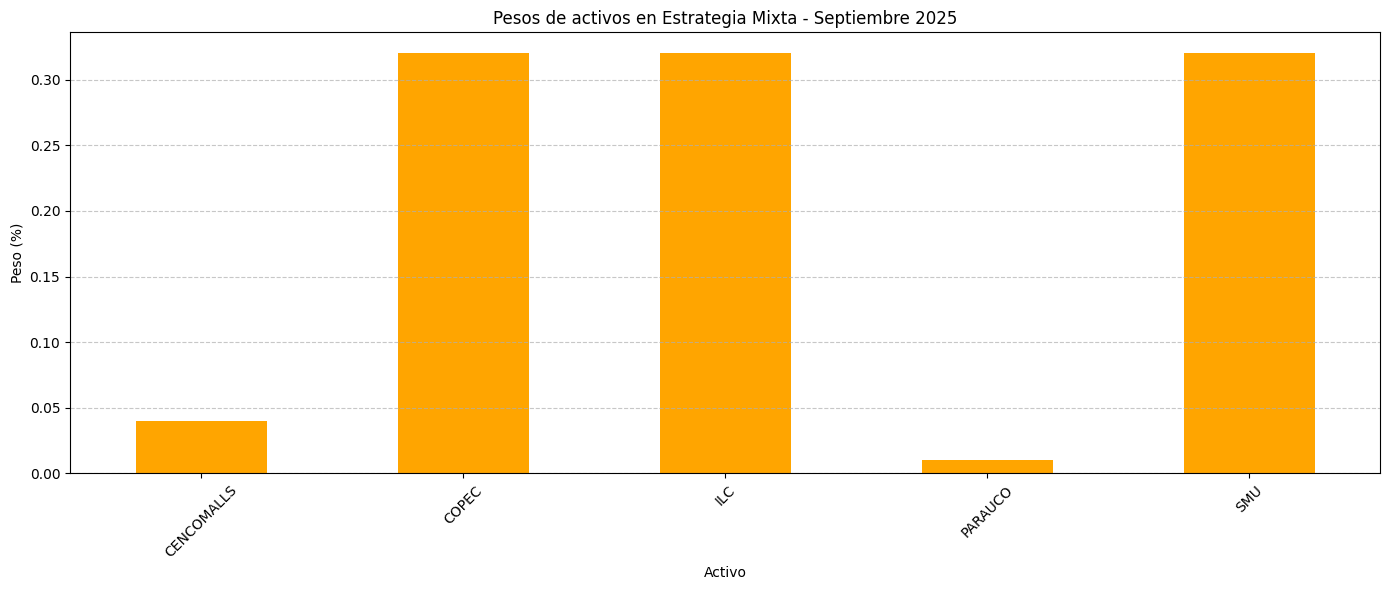

In [ ]:
import matplotlib.pyplot as plt

# Filtrar activos con peso > 0.001 y redondear
weights_sep = mixed.loc['2025-09-01'][mixed.loc['2025-09-01'] > 0.001].round(2)

# Crear gráfico de barras con mayor ancho
fig, ax = plt.subplots(figsize=(14, 6))  # más ancho

weights_sep.plot(kind='bar', color='orange', ax=ax)

# Personalizar el gráfico
ax.set_title('Pesos de activos en Estrategia Mixta - Septiembre 2025')
ax.set_ylabel('Peso (%)')
ax.set_xlabel('Activo')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Ajustar márgenes (izquierda, derecha, abajo, arriba)
plt.subplots_adjust(left=0.08, right=0.98, bottom=0.2, top=0.9)

# Mostrar
plt.tight_layout()
plt.show()
